## This is my attempt at implementing the RouBl algorithm

In [28]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm

EPS = 1e-5  # define a small constant for numerical stability control

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullCovGaussianNetwork(nn.Module):
    def __init__(self, layer_sizes, prior_std=0.1, init_std=0.1, alpha=0.1, gamma=0.01,
                 sqrt_width_scaling=False, device=None, dtype=None):
        
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianNetwork, self).__init__()

        self.layer_sizes = layer_sizes  # dimension of network layer input 
        self.dim_in = layer_sizes[0]
        self.dim_out = layer_sizes[-1]
        self.alpha = alpha
        self.gamma = gamma
        self.num_params = sum(dim_in * dim_out + dim_out for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]))

        # define and initialise the trainable variational parameters for q distribtuion
        self.mean = nn.Parameter(torch.zeros(self.num_params, **factory_kwargs), requires_grad=True)
        self.cov_chol = nn.Parameter(torch.tensor(torch.diag(init_std*torch.ones(self.num_params)), **factory_kwargs), requires_grad=True)

        cov_chol_inv = torch.linalg.inv(self.cov_chol)
        self.lambda_1 = cov_chol_inv @ torch.transpose(cov_chol_inv, 0, 1) @ self.mean
        
        # self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_param_std /= self.dim_in ** 0.5
            
        self.prior_std = prior_std

        # prior parameters are registered as constants
        self.register_buffer('prior_mean', torch.zeros(self.num_params, **factory_kwargs))
        self.register_buffer('prior_cov_chol', torch.tensor(torch.diag(prior_std*torch.ones(self.num_params)), **factory_kwargs))

    # I don't know what this is doing
    # def reset_parameters(self, init_std=0.5):
    #     nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
    #     bound = self.dim_in ** -0.5
    #     nn.init.uniform_(self.bias_mean, -bound, bound)
    #     _init_std_param = math.log(math.expm1(init_std))
    #     self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
    #     self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
   
    # @property
    # def scale_tril(self):
    #     # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
    #     # Only taking values below the main diagonal? no it takes everything below diagonal
    #     return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.cov_chol)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_cov_chol)
        kl = dist.kl_divergence(q, p).sum()
        return kl

    def sample_params(self):
        # Sample from q distribution and ensure requires_grad=True
        sample = self.mean + self.cov_chol @ torch.randn_like(self.mean)
        sample = sample.detach().requires_grad_(True)  # Ensure gradients can be computed
        return sample

    def forward(self, input, sampled_params):
        # Forward pass using the sampled parameters
        start = 0
        for i, (dim_in, dim_out) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            end = start + dim_out * dim_in
            weight = sampled_params[start:end].view(dim_out, dim_in)
            start = end
            end = start + dim_out
            bias = sampled_params[start:end]
            start = end
            input = F.linear(input, weight, bias)
            if i < len(self.layer_sizes) - 2:
                input = F.leaky_relu(input)
        return input

    def compute_param_gradients(self, input, K=500):
        gradients = torch.zeros(self.num_params, requires_grad=False)
        for k in range(K):
            sampled_params = self.sample_params()  # Sample from q distribution with gradient tracking
            output = self.forward(input, sampled_params)  # Forward pass
            output.backward()  # Backpropagate to calculate gradients

            # Gradient of output wrt each parameter in sampled_params
            gradients += sampled_params.grad
        return 1/K * gradients
    
    def update_variational_params(self, input, targets, K=500):
        grads = self.compute_param_gradients(input, K).resize(self.num_params, 1)
        grads_tp = grads.resize(1, self.num_params)
        with torch.no_grad():
            mu, sigma, alpha, gamma, lambda_1 = self.mean, self.cov_chol @ torch.transpose(self.cov_chol, 0, 1), self.alpha, self.gamma, self.lambda_1

            sigma_tilde = 1 / (1 - alpha*gamma) * sigma
            sigma = sigma_tilde - (alpha * sigma_tilde @ grads @ grads_tp @ sigma_tilde) / (1 + alpha * grads_tp @ sigma_tilde @ grads)
            
            nu = grads_tp @ mu
            lambda_1 = (1 - alpha*gamma) * lambda_1 - alpha*(1 - nu) * grads

        self.mean = nn.Parameter(sigma @ lambda_1, requires_grad=True)
        self.cov_chol = nn.Parameter(torch.linalg.cholesky(sigma), requires_grad=True)

# Example usage
net = FullCovGaussianNetwork([1, 2, 1], prior_std=0.1, init_std=0.1)
input_data = torch.tensor([1.0], requires_grad=True)
targets = torch.tensor([2.0], requires_grad=False)

# Compute the gradients wrt the sampled network parameters
grads = net.compute_param_gradients(input_data, 10).resize(1,net.num_params)
grads_tp = param_grads.resize(net.num_params,1)

net.update_variational_params(input_data, targets, K=500)


/tmp/ipykernel_71963/3916353961.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.cov_chol = nn.Parameter(torch.tensor(torch.diag(init_std*torch.ones(self.num_params)), **factory_kwargs), requires_grad=True)
/tmp/ipykernel_71963/3916353961.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('prior_cov_chol', torch.tensor(torch.diag(prior_std*torch.ones(self.num_params)), **factory_kwargs))
/usr/local/python/3.12.1/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


### Regression Ground Truth

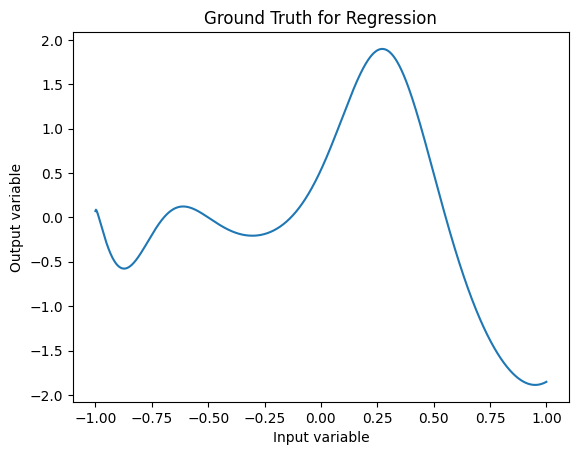

In [30]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return 15*np.cos(0.1/(0.05*(x+1)+0.02)) + 3*np.exp(0.5*np.sin(((50*(x+1))**0.9-3)/5))/((50*(x+1)+0.01)**(-0.5)) -12.5*(x+1)**2

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(xs)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

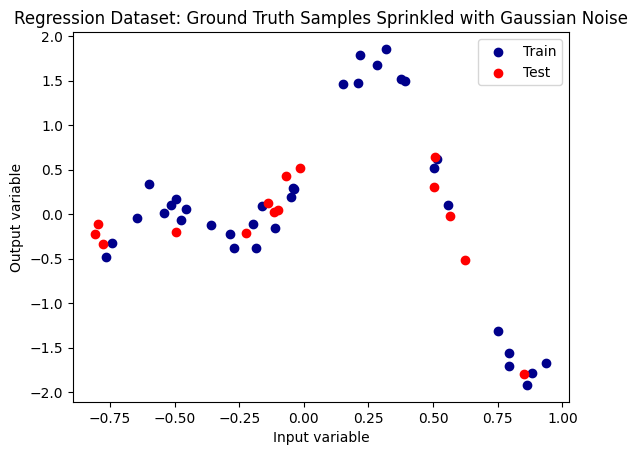

In [31]:
def generate_dataset(size=50, noise=0.15, split=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=split, random_state=13)

x_tr, x_te, y_tr, y_te = generate_dataset()
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

### Training

In [32]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_epochs = 2

for epoch in tqdm(range(n_epochs)):
    

SyntaxError: incomplete input (184787273.py, line 5)